# Importing the dataset and loaded the data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler



# Load the dataset from the provided URL
url = "https://raw.githubusercontent.com/ouladsayadyounes/WildFires/master/WildFires_DataSet.csv"

# Read the dataset
df = pd.read_csv(url)

# Rename the 'BURNED_AREA' column to 'THERMAL_ANOMALIES'
df.rename(columns={"BURNED_AREA": "THERMAL_ANOMALIES"}, inplace=True)


# Display the first few rows of the dataset
df.head()


,NDVI,LST,THERMAL_ANOMALIES,CLASS
0,0.506782,14584.272727,4.692308,no_fire
1,0.522150,14655.833333,5.000000,no_fire
2,0.682284,14780.000000,5.000000,fire
3,0.120046,13298.500000,3.500000,no_fire
4,0.568734,14743.000000,5.000000,no_fire


# Importing all necessary libraries

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')


# Checks the basic info. of dataset

In [ ]:
print("Missing values:\n", df.isnull().sum())

# Remove duplicates if any
df = df.drop_duplicates()

# Check basic information about the dataset
print("\nDataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())


Missing values:
 NDVI                 0
LST                  0
THERMAL_ANOMALIES    0
CLASS                0
dtype: int64

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1438 entries, 0 to 1712
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NDVI               1438 non-null   float64
 1   LST                1438 non-null   float64
 2   THERMAL_ANOMALIES  1438 non-null   float64
 3   CLASS              1438 non-null   object 
dtypes: float64(3), object(1)
memory usage: 56.2+ KB
None

Basic Statistics:
              NDVI           LST  THERMAL_ANOMALIES
count  1438.000000   1438.000000        1438.000000
mean      0.554907  14626.952097           4.670910
std       0.093915    364.897101           0.580965
min       0.030735  13137.000000           3.000000
25%       0.500103  14409.162909           4.513794
50%       0.564024  14651.083333           4.915373
75%       0.620798  14884.000000 

# Check for outliers using IQR method


In [ ]:
# Check for outliers using Interquartile Range method
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    print(f"\nOutliers in {col}: {len(outliers)}")




Outliers in NDVI: 19

Outliers in LST: 13

Outliers in THERMAL_ANOMALIES: 132


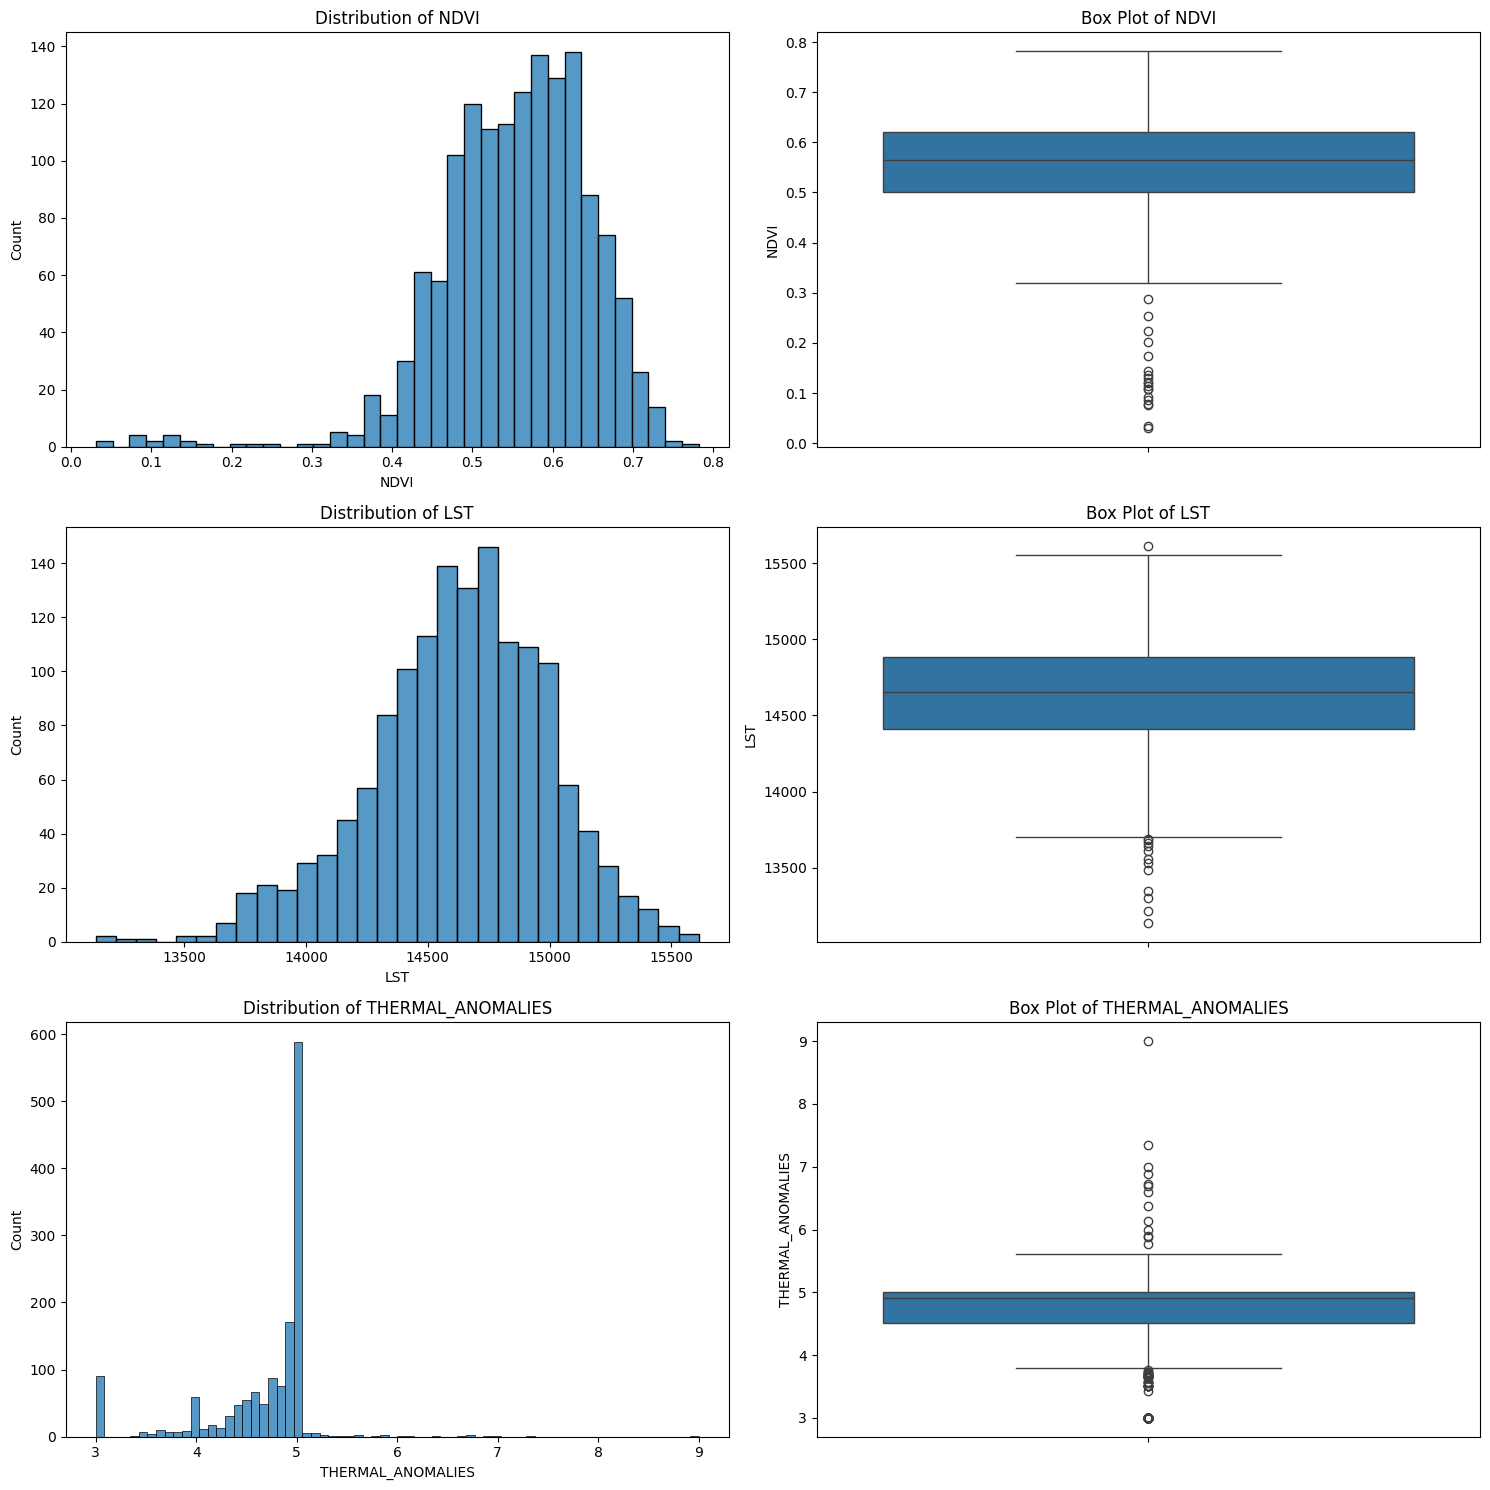

In [ ]:
# Distribution plots for numeric columns
plt.figure(figsize=(15, 5*len(numeric_cols)))
for idx, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 2, 2*idx-1)
    sns.histplot(data=df, x=col)
    plt.title(f'Distribution of {col}')

    plt.subplot(len(numeric_cols), 2, 2*idx)
    sns.boxplot(data=df, y=col)
    plt.title(f'Box Plot of {col}')

plt.tight_layout()
plt.show()

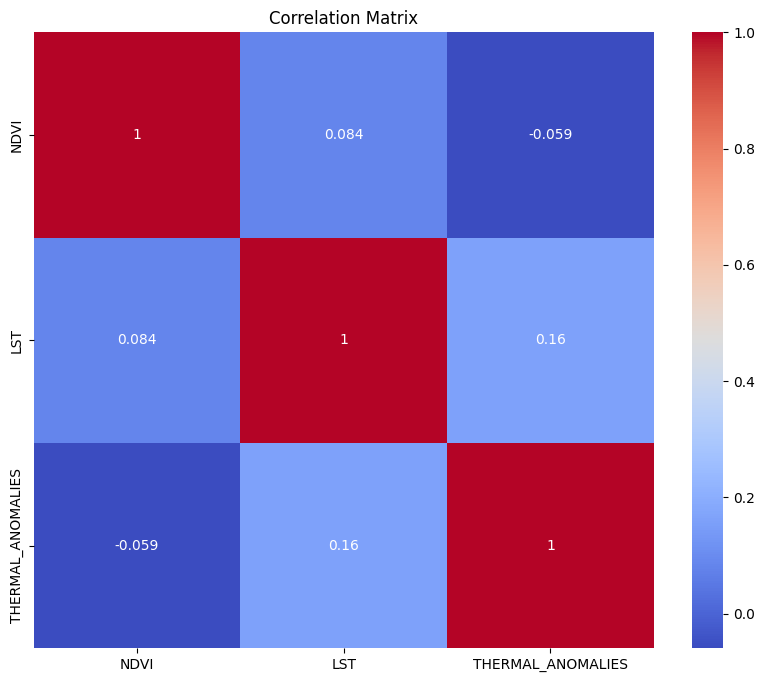

In [ ]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Density-Based Spatial Clustering of Applications with Noise

Text(0.5, 1.0, 'DBSCAN Clustering')

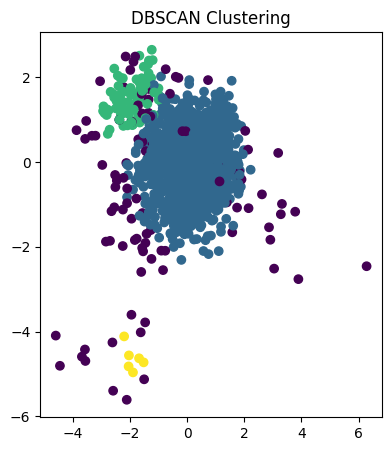

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numeric_cols])

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 1. DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5) #0.5 distance of neighborhood and min points to form a region
dbscan_labels = dbscan.fit_predict(X_scaled)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis')
plt.title('DBSCAN Clustering')

In [ ]:
# Print DBSCAN results
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"\nDBSCAN found {n_clusters_dbscan} clusters")
print(f"Number of noise points: {list(dbscan_labels).count(-1)}")



DBSCAN found 3 clusters
Number of noise points: 96


# OPTICS Clustering (Ordering Points To Identify the Clustering Structure)


OPTICS found 68 clusters
Number of noise points: 903

GMM with 3 components
BIC score: 5908.8410794648435
AIC score: 5755.981831854695


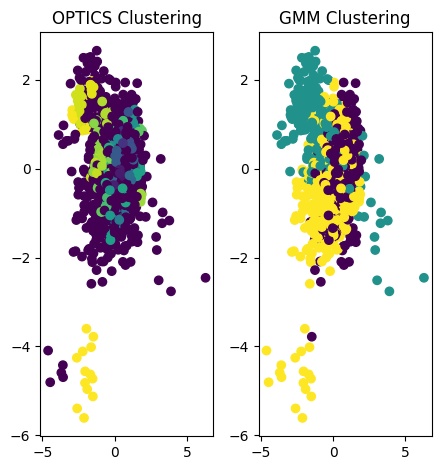

In [ ]:
# 2. OPTICS Clustering
optics = OPTICS(min_samples=5)
optics_labels = optics.fit_predict(X_scaled)

plt.subplot(132)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=optics_labels, cmap='viridis')
plt.title('OPTICS Clustering')

# Print OPTICS results
n_clusters_optics = len(set(optics_labels)) - (1 if -1 in optics_labels else 0)
print(f"\nOPTICS found {n_clusters_optics} clusters")
print(f"Number of noise points: {list(optics_labels).count(-1)}")

# 3. Gaussian Mixture Model
n_components = 3  # You can adjust this
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)

plt.subplot(133)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='viridis')
plt.title('GMM Clustering')

# Print GMM results
print(f"\nGMM with {n_components} components")
print("BIC score:", gmm.bic(X_scaled))
print("AIC score:", gmm.aic(X_scaled))

plt.tight_layout()
plt.show()

Key Features in the Dataset:
Normalized Difference Vegetation Index (NDVI) – Crop & Vegetation Health

NDVI measures vegetation greenness and density.
Dry, stressed, or sparse vegetation is more likely to catch fire.
Lower NDVI values indicate higher wildfire risk.
Land Surface Temperature (LST) – Meteorological Condition

LST provides ground temperature measurements.
Higher surface temperatures can increase fire likelihood.
Combining LST and NDVI helps assess drought conditions and vegetation dryness.

In [ ]:
# Ensure CLASS column is properly mapped and handle missing values
df["CLASS"] = df["CLASS"].replace({"no_fire": 0, "fire": 1})

# Fill any remaining NaN values in CLASS with 0 (assuming no fire)
df["CLASS"] = df["CLASS"].fillna(0).astype(int)

# Fill missing values with column mean instead of dropping them
df.fillna(df.mean(), inplace=True)

df_scaled = df.copy()

# Use MinMaxScaler to keep values between 0 and 1
scaler = MinMaxScaler()
df_scaled[["NDVI", "LST", "THERMAL_ANOMALIES"]] = scaler.fit_transform(df[["NDVI", "LST", "THERMAL_ANOMALIES"]])


# Display the first few rows of the cleaned dataset
df_scaled.head()


<ipython-input-58-3ae30468f7ca>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["CLASS"] = df["CLASS"].replace({"no_fire": 0, "fire": 1})


,NDVI,LST,THERMAL_ANOMALIES,CLASS
0,0.633894,0.584858,0.282051,0
1,0.654358,0.613777,0.333333,0
2,0.867589,0.663954,0.333333,1
3,0.118925,0.065264,0.083333,0
4,0.716388,0.649002,0.333333,0


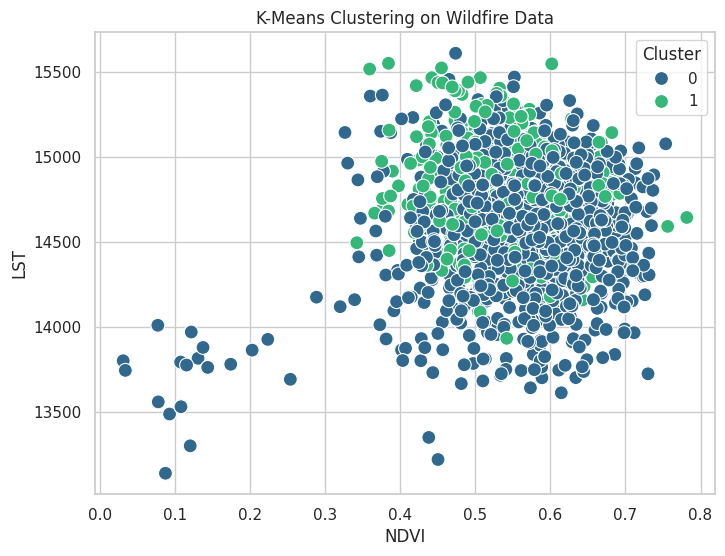

          NDVI           LST  THERMAL_ANOMALIES  CLASS  Cluster
0     0.506782  14584.272727           4.692308      0        0
1     0.522150  14655.833333           5.000000      0        0
2     0.682284  14780.000000           5.000000      1        1
3     0.120046  13298.500000           3.500000      0        0
4     0.568734  14743.000000           5.000000      0        0
...        ...           ...                ...    ...      ...
1708  0.621721  14406.000000           5.000000      0        0
1709  0.709715  14330.400000           4.851852      0        0
1710  0.613000  14751.500000           3.000000      1        1
1711  0.614471  13611.000000           4.921053      0        0
1712  0.549497  14269.777778           5.000000      1        1

[1713 rows x 5 columns]


In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardizing the features for K-Means clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)

# Applying K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(scaled_features)

# Visualizing the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df["NDVI"], y=df["LST"], hue=df["Cluster"], palette="viridis", s=100
)
plt.xlabel("NDVI")
plt.ylabel("LST")
plt.title("K-Means Clustering on Wildfire Data")
plt.legend(title="Cluster")
plt.show()

# Display the clustered data
print(df)

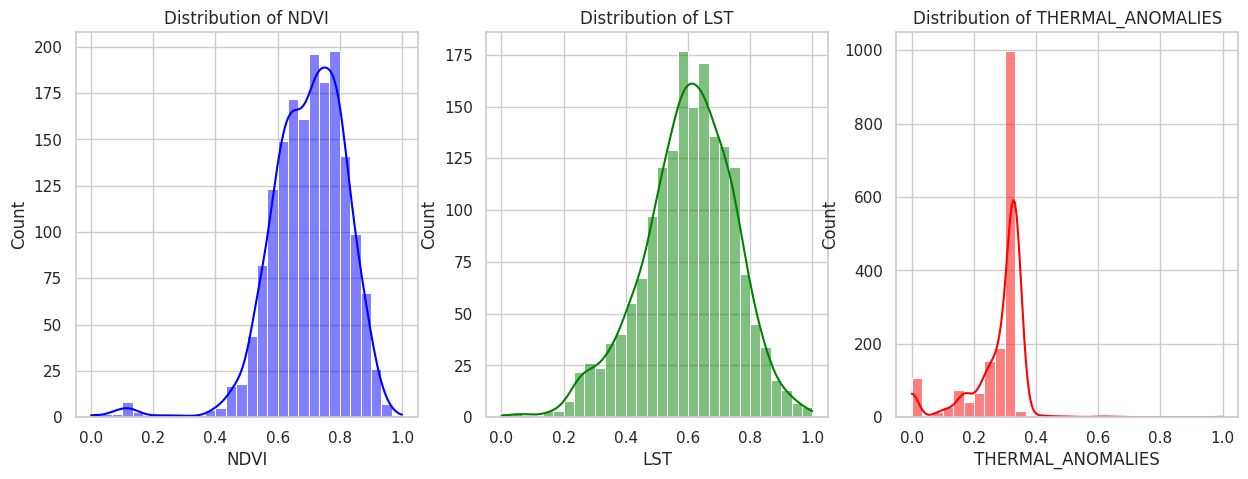

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Plot the distribution of NDVI, LST, and BURNED_AREA
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(df_scaled["NDVI"], bins=30, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Distribution of NDVI")

sns.histplot(df_scaled["LST"], bins=30, kde=True, ax=axes[1], color="green")
axes[1].set_title("Distribution of LST")

sns.histplot(df_scaled["THERMAL_ANOMALIES"], bins=30, kde=True, ax=axes[2], color="red")
axes[2].set_title("Distribution of THERMAL_ANOMALIES")

plt.show()

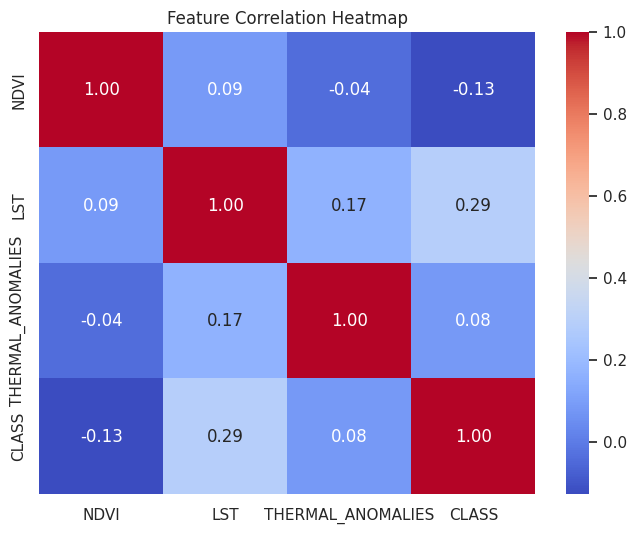

In [ ]:
# Plotting the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_scaled.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


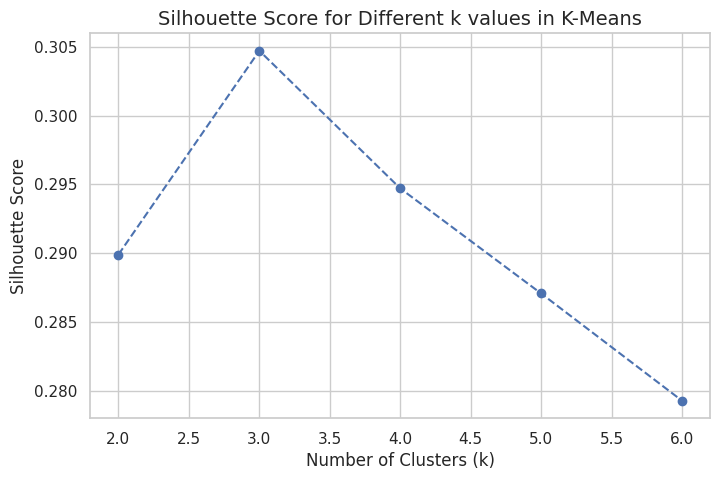

The optimal number of clusters (k) based on silhouette score is: 3
Silhouette scores for k values: {2: 0.28989917405130256, 3: 0.3047030878537228, 4: 0.29470554457337683, 5: 0.28707363191388896, 6: 0.2792844158126529}


In [ ]:
# Test K-Means with different values of k and compute silhouette scores
from sklearn.metrics import silhouette_score

# Range of k values to test
k_values = range(2, 7)  # Testing k from 2 to 6
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_scaled[["NDVI", "LST", "THERMAL_ANOMALIES"]])
    score = silhouette_score(df_scaled[["NDVI", "LST", "THERMAL_ANOMALIES"]], labels)
    silhouette_scores.append(score)

# Plot silhouette scores for different k values
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker="o", linestyle="--", color="b")
plt.title("Silhouette Score for Different k values in K-Means", fontsize=14)
plt.xlabel("Number of Clusters (k)", fontsize=12)
plt.ylabel("Silhouette Score", fontsize=12)
plt.grid(True)
plt.show()

# Display the best k value based on silhouette score
best_k = k_values[silhouette_scores.index(max(silhouette_scores))]
print(f"The optimal number of clusters (k) based on silhouette score is: {best_k}")
print(f"Silhouette scores for k values: {dict(zip(k_values, silhouette_scores))}")


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Assuming 3 clusters for demonstration
kmeans_labels = kmeans.fit_predict(df_scaled[["NDVI", "LST", "THERMAL_ANOMALIES"]])

# Add cluster labels to the dataset
df_scaled["Cluster"] = kmeans_labels

# Evaluate clustering with silhouette score
silhouette_avg = silhouette_score(df_scaled[["NDVI", "LST", "THERMAL_ANOMALIES"]], kmeans_labels)

# Display results
print(f"Silhouette Score for K-Means Clustering: {silhouette_avg}")
df_scaled.head()


Silhouette Score for K-Means Clustering: 0.3047030878537228


,NDVI,LST,THERMAL_ANOMALIES,CLASS,Cluster
0,0.633894,0.584858,0.282051,0,1
1,0.654358,0.613777,0.333333,0,0
2,0.867589,0.663954,0.333333,1,0
3,0.118925,0.065264,0.083333,0,1
4,0.716388,0.649002,0.333333,0,0


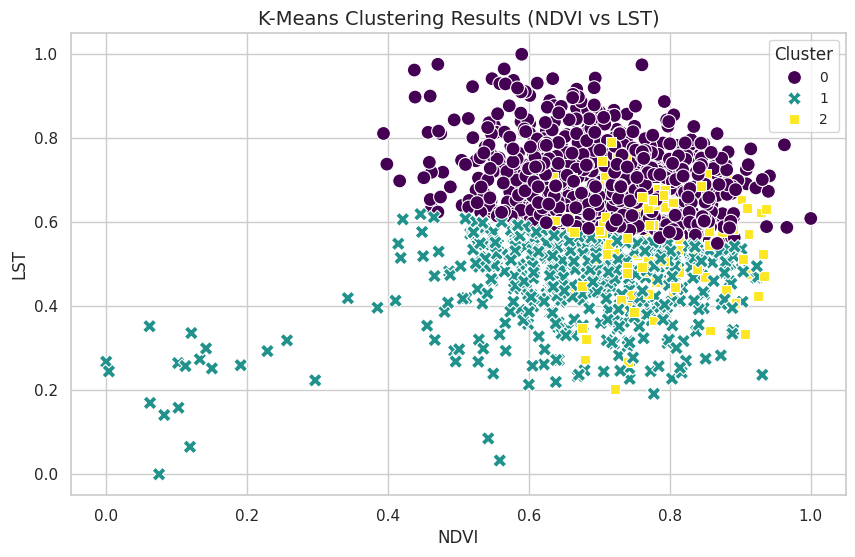

In [ ]:
# Visualizing the clusters with a 2D scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=df_scaled["NDVI"],
    y=df_scaled["LST"],
    hue=df_scaled["Cluster"],
    palette="viridis",
    style=df_scaled["Cluster"],
    s=100,
)
plt.title("K-Means Clustering Results (NDVI vs LST)", fontsize=14)
plt.xlabel("NDVI", fontsize=12)
plt.ylabel("LST", fontsize=12)
plt.legend(title="Cluster", fontsize=10)
plt.grid(True)
plt.show()


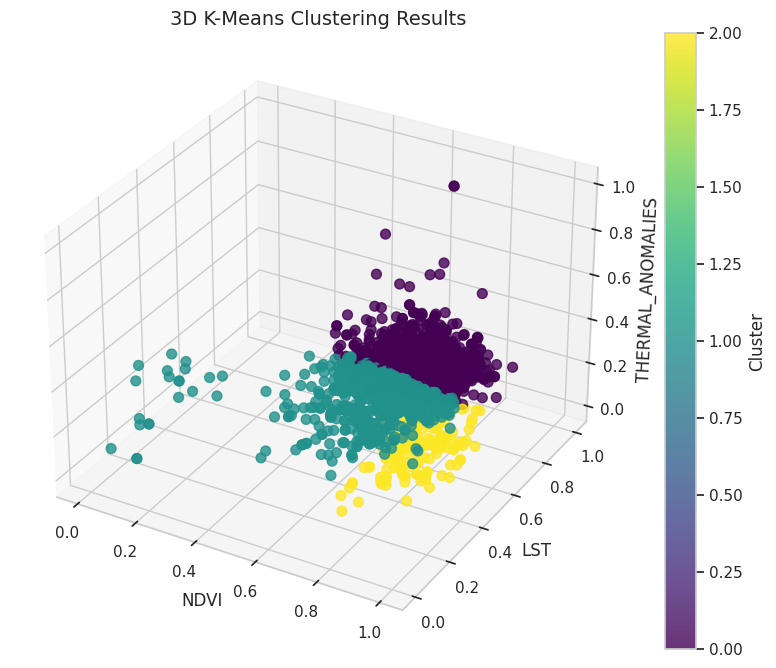

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# 3D Visualization: NDVI, LST, and BURNED_AREA with cluster labels
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

scatter = ax.scatter(
    df_scaled["NDVI"],
    df_scaled["LST"],
    df_scaled["THERMAL_ANOMALIES"],
    c=df_scaled["Cluster"],
    cmap="viridis",
    s=50,
    alpha=0.8,
)

ax.set_title("3D K-Means Clustering Results", fontsize=14)
ax.set_xlabel("NDVI", fontsize=12)
ax.set_ylabel("LST", fontsize=12)
ax.set_zlabel("THERMAL_ANOMALIES", fontsize=12)
fig.colorbar(scatter, ax=ax, label="Cluster")
plt.show()


Observations:
Cluster Separation:

There is some visible separation between the clusters, especially along the NDVI, LST, and THERMAL_ANAMOLIES axes.
The yellow cluster appears distinct, while the purple and teal clusters may have some overlap.
Cluster Characteristics:

If these clusters are linked to fire risk, it may indicate different zones of fire likelihood based on vegetation health (NDVI), land surface temperature (LST), and burned area.
Validation:

To validate the quality of clustering, you can check metrics such as the silhouette score or interpret the cluster centroids.

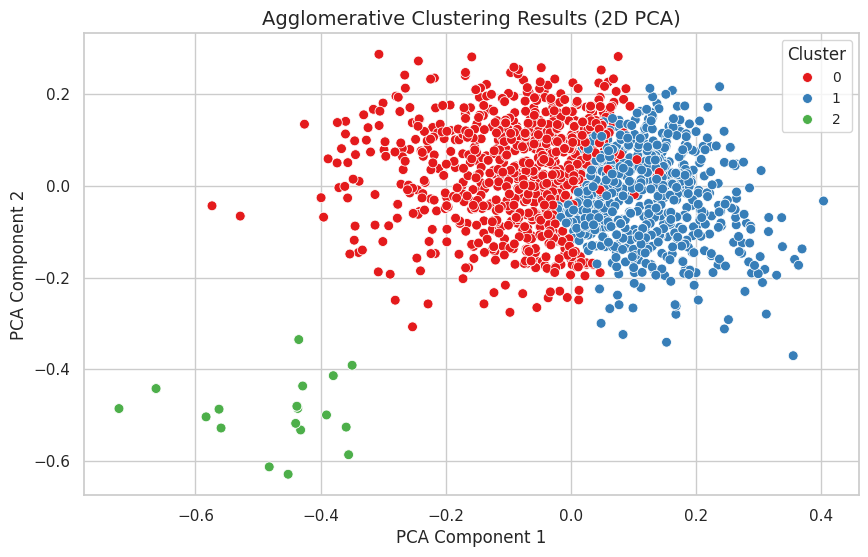

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.decomposition import PCA

from sklearn.cluster import AgglomerativeClustering
pca = PCA(n_components=2)
data_pca = pca.fit_transform(df_scaled[["NDVI", "LST", "THERMAL_ANOMALIES"]])


# Apply Agglomerative Clustering
agg_cluster = AgglomerativeClustering(n_clusters=3)  # Assuming 3 clusters for comparison
agg_labels = agg_cluster.fit_predict(df_scaled[["NDVI", "LST", "THERMAL_ANOMALIES"]])

# Add Agglomerative cluster labels to the dataset
df_scaled["Agglomerative_Cluster"] = agg_labels

# Visualize Agglomerative Clustering Results in 2D (using PCA components)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=agg_labels, palette="Set1", s=50)
plt.title("Agglomerative Clustering Results (2D PCA)", fontsize=14)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.legend(title="Cluster", fontsize=10)
plt.grid(True)
plt.show()




---



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1713 entries, 0 to 1712
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   NDVI         1713 non-null   float64
 1   LST          1713 non-null   float64
 2   BURNED_AREA  1713 non-null   float64
 3   CLASS        1713 non-null   object 
dtypes: float64(3), object(1)
memory usage: 53.7+ KB
              NDVI           LST  BURNED_AREA
count  1713.000000   1713.000000  1713.000000
mean      0.555665  14622.802073     4.674973
std       0.092847    366.927861     0.583791
min       0.030735  13137.000000     3.000000
25%       0.501276  14406.000000     4.521951
50%       0.565181  14645.750000     4.920635
75%       0.620987  14881.300000     5.000000
max       0.781723  15611.570513     9.000000


<ipython-input-37-8824f06c961c>:50: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x="NDVI", y="LST", palette="cool", alpha=0.7)


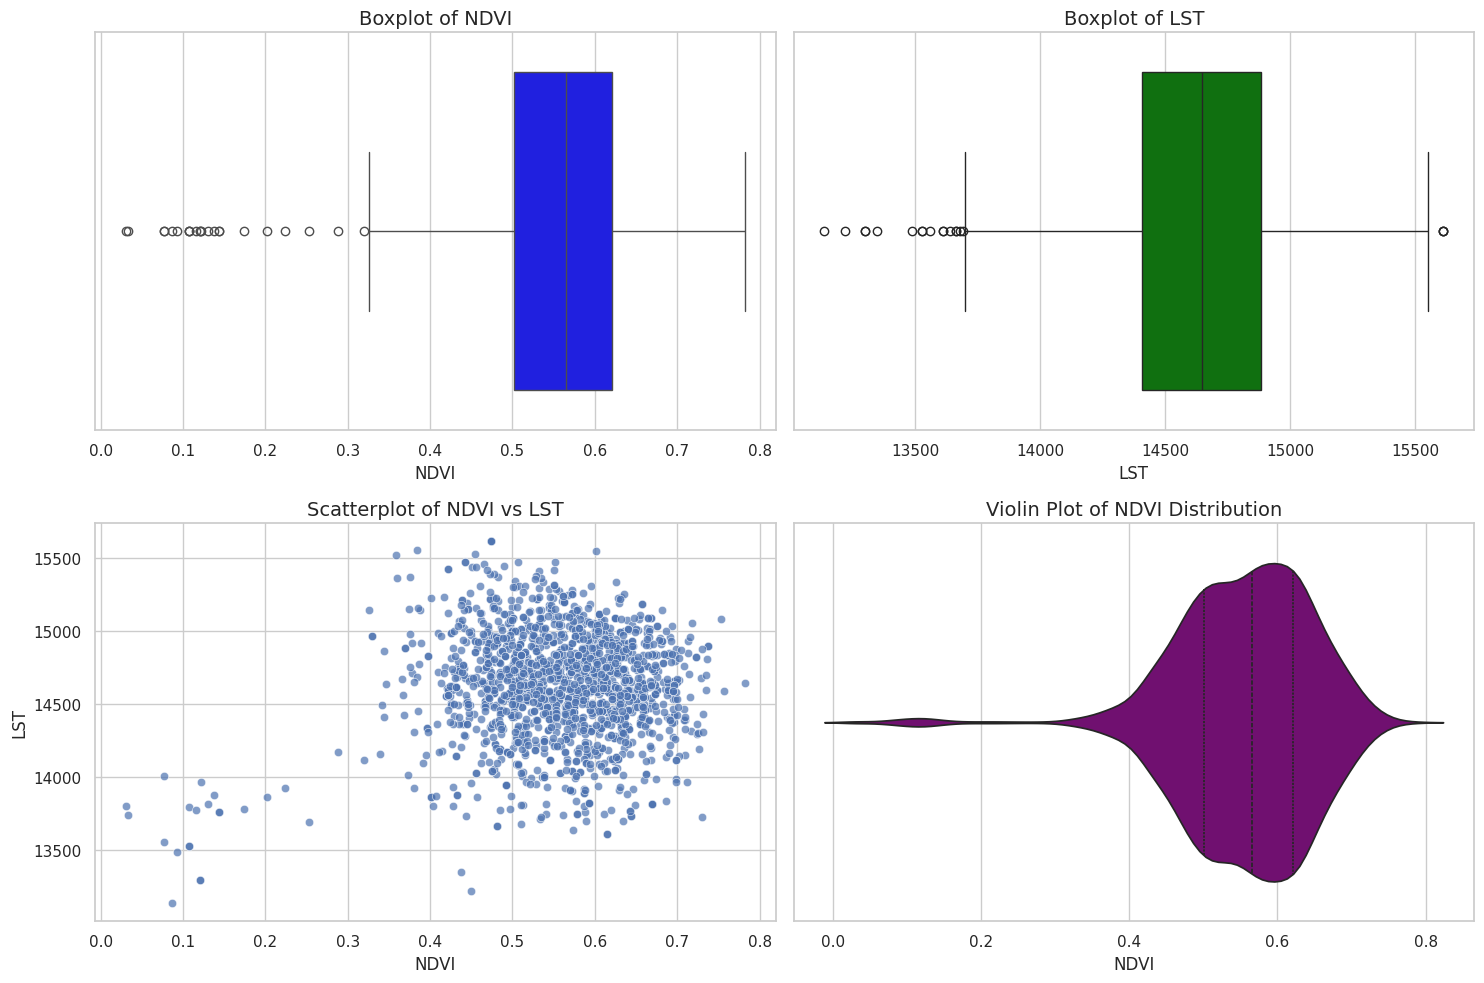

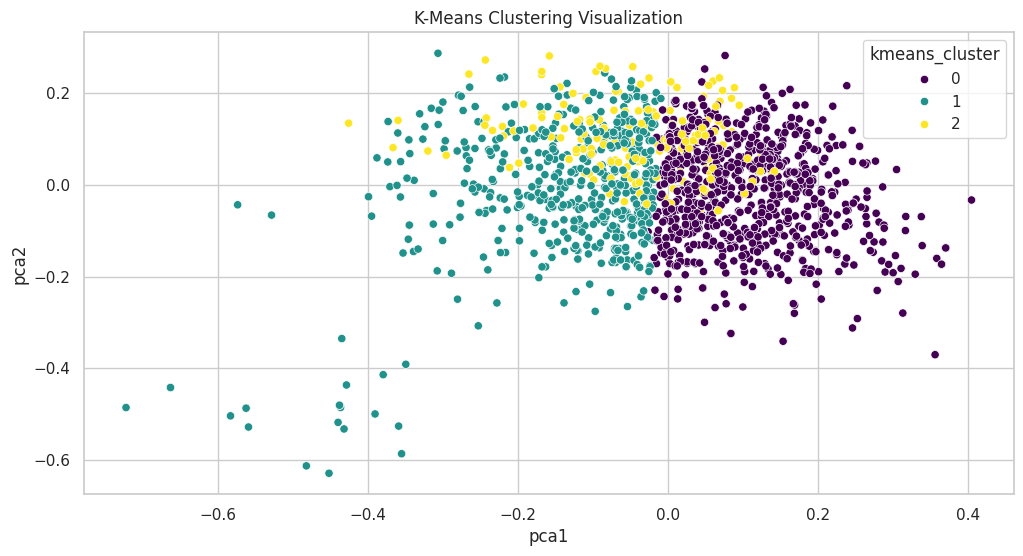

Epoch [10/50], Loss: 0.0192
Epoch [20/50], Loss: 0.0161
Epoch [30/50], Loss: 0.0163
Epoch [40/50], Loss: 0.0155
Epoch [50/50], Loss: 0.0149


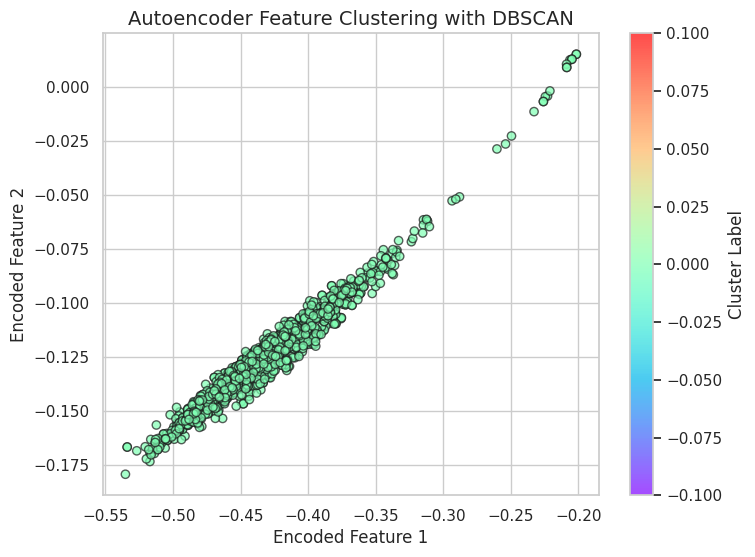

Number of clusters: 1
DBSCAN cluster labels: {0}


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
url = "https://raw.githubusercontent.com/ouladsayadyounes/WildFires/master/WildFires_DataSet.csv"
df = pd.read_csv(url)

# Display basic info
df.info()
print(df.describe())

# Data Wrangling: Handling missing values
df = df.dropna()

# Selecting numerical features for clustering
num_features = df.select_dtypes(include=[np.number]).columns.tolist()
df_filtered = df[num_features]

# Normalizing the data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_filtered)

plt.figure(figsize=(15, 10))

# Boxplot for NDVI
plt.subplot(2, 2, 1)
sns.boxplot(data=df, x="NDVI", color="blue")
plt.title("Boxplot of NDVI", fontsize=14)
plt.xlabel("NDVI", fontsize=12)

# Boxplot for LST
plt.subplot(2, 2, 2)
sns.boxplot(data=df, x="LST", color="green")
plt.title("Boxplot of LST", fontsize=14)
plt.xlabel("LST", fontsize=12)

# Scatter plot for NDVI vs LST
plt.subplot(2, 2, 3)
sns.scatterplot(data=df, x="NDVI", y="LST", palette="cool", alpha=0.7)
plt.title("Scatterplot of NDVI vs LST", fontsize=14)
plt.xlabel("NDVI", fontsize=12)
plt.ylabel("LST", fontsize=12)

# Violin plot for NDVI distribution
plt.subplot(2, 2, 4)
sns.violinplot(data=df, x="NDVI", color="purple", inner="quartile")
plt.title("Violin Plot of NDVI Distribution", fontsize=14)
plt.xlabel("NDVI", fontsize=12)


plt.tight_layout()
plt.show()


# Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(df_scaled)

# Apply DBSCAN as an alternative clustering method
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['dbscan_cluster'] = dbscan.fit_predict(df_scaled)

# PCA for visualization
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df['pca1'] = df_pca[:, 0]
df['pca2'] = df_pca[:, 1]

# Plot clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df['pca1'], y=df['pca2'], hue=df['kmeans_cluster'], palette='viridis')
plt.title('K-Means Clustering Visualization')
plt.show()

# Split into train and test sets
X_train, X_test = train_test_split(df_scaled, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Define Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  # Encoded 2D representation
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Initialize model, loss function, and optimizer
input_dim = df_scaled.shape[1]
autoencoder = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)

# Train Autoencoder
num_epochs = 50
for epoch in range(num_epochs):
    optimizer.zero_grad()
    encoded, decoded = autoencoder(X_train_tensor)
    loss = criterion(decoded, X_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Extract encoded features
encoded_data, _ = autoencoder(X_train_tensor)
df_encoded = encoded_data.detach().numpy()

# Apply DBSCAN on encoded representations
dbscan_auto = DBSCAN(eps=0.8, min_samples=3)
dbscan_labels = dbscan_auto.fit_predict(df_encoded)

# Plot DBSCAN Clustering Results
plt.figure(figsize=(8, 6))
plt.scatter(df_encoded[:, 0], df_encoded[:, 1], c=dbscan_labels, cmap='rainbow', alpha=0.7, edgecolors='k')
plt.title("Autoencoder Feature Clustering with DBSCAN", fontsize=14)
plt.xlabel("Encoded Feature 1", fontsize=12)
plt.ylabel("Encoded Feature 2", fontsize=12)
plt.colorbar(label="Cluster Label")
plt.show()

# Print DBSCAN clustering information
num_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"Number of clusters: {num_clusters}")
print(f"DBSCAN cluster labels: {set(dbscan_labels)}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1713 entries, 0 to 1712
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   NDVI         1713 non-null   float64
 1   LST          1713 non-null   float64
 2   BURNED_AREA  1713 non-null   float64
 3   CLASS        1713 non-null   object 
dtypes: float64(3), object(1)
memory usage: 53.7+ KB
              NDVI           LST  BURNED_AREA
count  1713.000000   1713.000000  1713.000000
mean      0.555665  14622.802073     4.674973
std       0.092847    366.927861     0.583791
min       0.030735  13137.000000     3.000000
25%       0.501276  14406.000000     4.521951
50%       0.565181  14645.750000     4.920635
75%       0.620987  14881.300000     5.000000
max       0.781723  15611.570513     9.000000


<ipython-input-45-8de068cb654c>:50: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x="NDVI", y="LST", palette="cool", alpha=0.7)


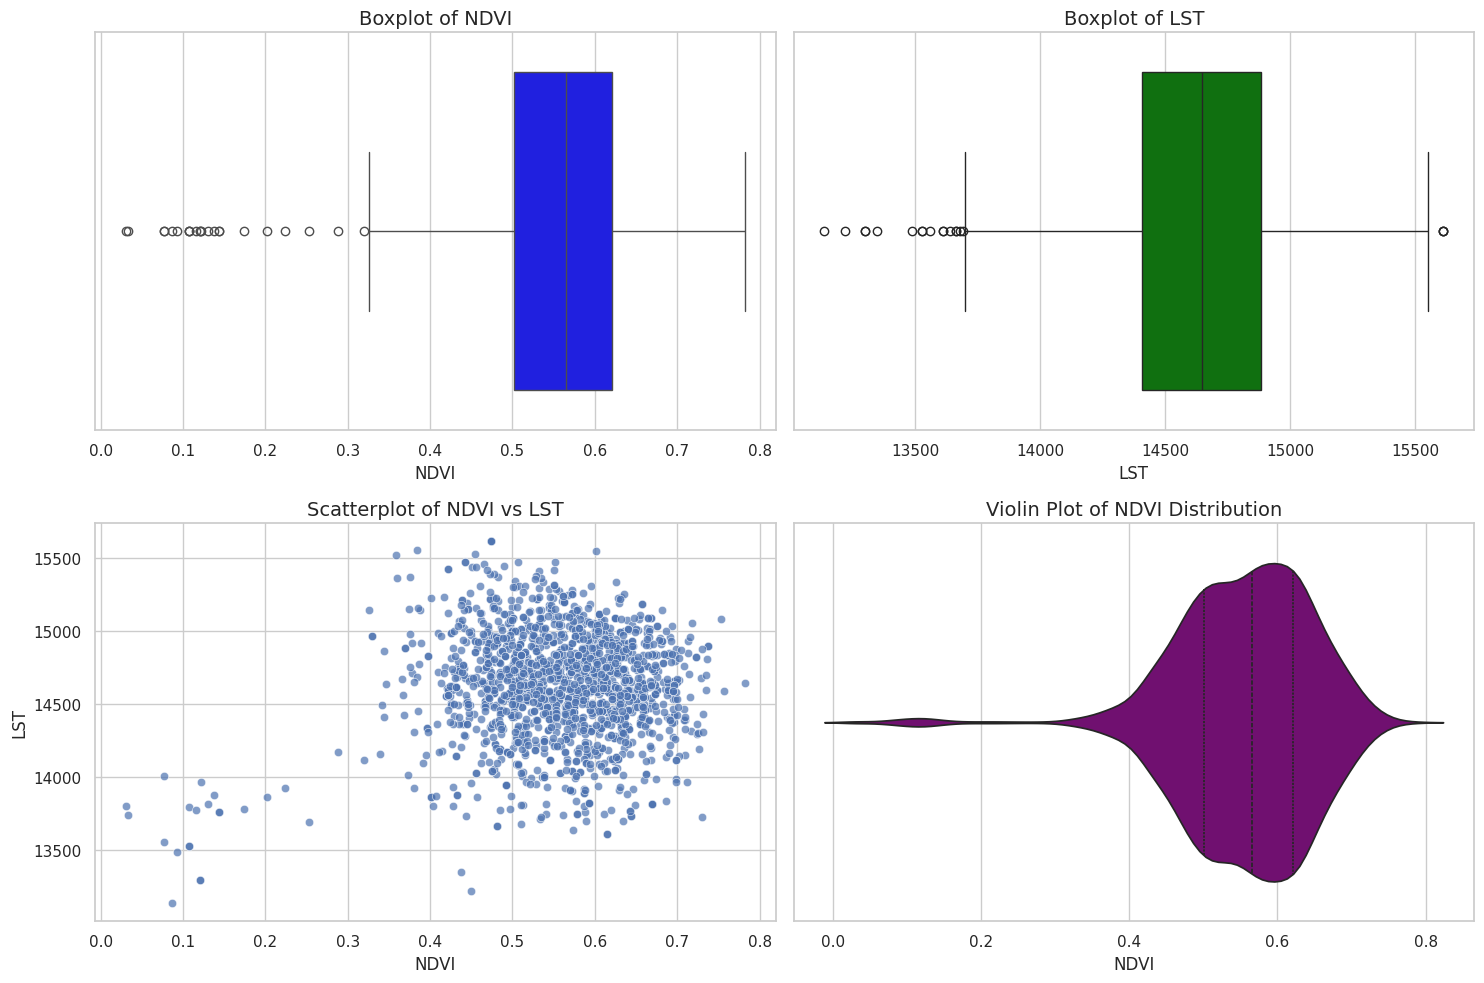

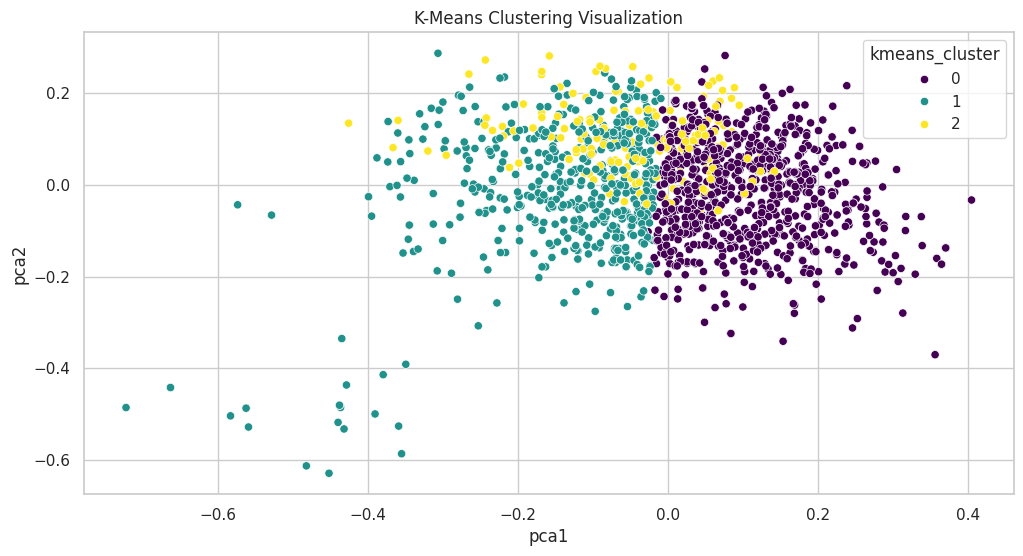

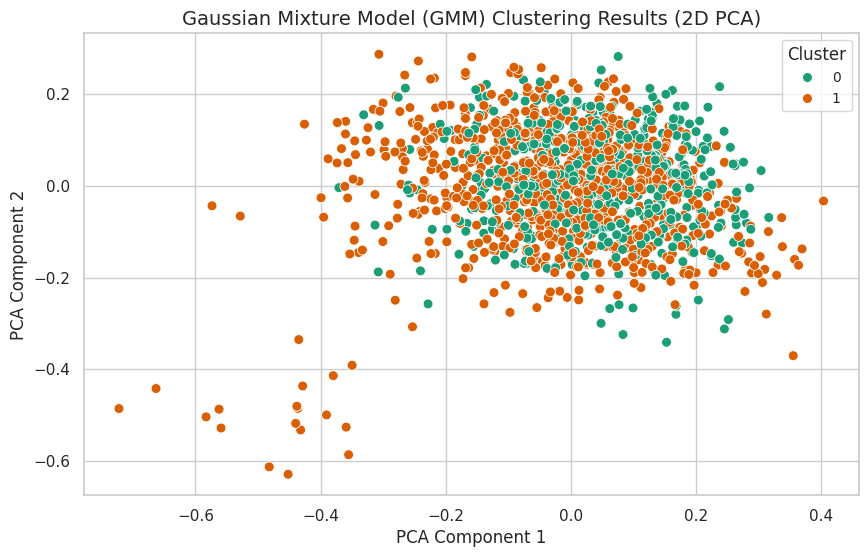

Number of clusters detected by GMM: 2


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
url = "https://raw.githubusercontent.com/ouladsayadyounes/WildFires/master/WildFires_DataSet.csv"
df = pd.read_csv(url)

# Display basic info
df.info()
print(df.describe())

# Data Wrangling: Handling missing values
df = df.dropna()

# Selecting numerical features for clustering
num_features = df.select_dtypes(include=[np.number]).columns.tolist()
df_filtered = df[num_features]

# Normalizing the data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_filtered)

plt.figure(figsize=(15, 10))

# Boxplot for NDVI
plt.subplot(2, 2, 1)
sns.boxplot(data=df, x="NDVI", color="blue")
plt.title("Boxplot of NDVI", fontsize=14)
plt.xlabel("NDVI", fontsize=12)

# Boxplot for LST
plt.subplot(2, 2, 2)
sns.boxplot(data=df, x="LST", color="green")
plt.title("Boxplot of LST", fontsize=14)
plt.xlabel("LST", fontsize=12)

# Scatter plot for NDVI vs LST
plt.subplot(2, 2, 3)
sns.scatterplot(data=df, x="NDVI", y="LST", palette="cool", alpha=0.7)
plt.title("Scatterplot of NDVI vs LST", fontsize=14)
plt.xlabel("NDVI", fontsize=12)
plt.ylabel("LST", fontsize=12)

# Violin plot for NDVI distribution
plt.subplot(2, 2, 4)
sns.violinplot(data=df, x="NDVI", color="purple", inner="quartile")
plt.title("Violin Plot of NDVI Distribution", fontsize=14)
plt.xlabel("NDVI", fontsize=12)


plt.tight_layout()
plt.show()


# Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(df_scaled)

# Apply DBSCAN as an alternative clustering method
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['dbscan_cluster'] = dbscan.fit_predict(df_scaled)

# PCA for visualization
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df['pca1'] = df_pca[:, 0]
df['pca2'] = df_pca[:, 1]

# Plot clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df['pca1'], y=df['pca2'], hue=df['kmeans_cluster'], palette='viridis')
plt.title('K-Means Clustering Visualization')
plt.show()

from sklearn.mixture import GaussianMixture

# Convert scaled data back to a DataFrame with proper column names
df_scaled = pd.DataFrame(df_scaled, columns=["NDVI", "LST", "THERMAL_ANOMALIES"])

# Apply Gaussian Mixture Model (GMM) Clustering
gmm = GaussianMixture(n_components=2, covariance_type='diag', random_state=42)

gmm_labels = gmm.fit_predict(df_scaled[["NDVI", "LST", "THERMAL_ANOMALIES"]])

# Add GMM cluster labels to the dataset
df_scaled["GMM_Cluster"] = gmm_labels

# Visualize GMM Clustering Results in 2D (using PCA components)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=gmm_labels, palette="Dark2", s=50)
plt.title("Gaussian Mixture Model (GMM) Clustering Results (2D PCA)", fontsize=14)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.legend(title="Cluster", fontsize=10)
plt.grid(True)
plt.show()

# Print the number of unique clusters detected
num_clusters_gmm = len(set(gmm_labels))
print(f"Number of clusters detected by GMM: {num_clusters_gmm}")
